<a href="https://colab.research.google.com/github/pidipidi/cs577_RLI/blob/master/LLM_VLM_Planner_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM/VLM-based Task Planning

This notebook demonstrates the implementation of a task planner using LLM/VLM and its integration with [AI2-THOR simulation](https://ai2thor.allenai.org/).
We explore three prompting strategies—Zero-Shot, Few-Shot, and Multimodal—to generate JSON-formatted plans, parse them into high-level actions, and execute them in the AI2-THOR kitchen environment.

---

## General information

### Objectives

- Initialize the AI2-THOR simulation environment  
- Construct prompts for **Zero-Shot**, **Few-Shot**, and **Multimodal** planning  
- Generate JSON-based plans using ChatGPT or other LLMs/VLMs  
- Execute and validate the plans step-by-step in AI2-THOR  

### Table of Contents

- **Environment Setup**  
  - Install required libraries  
  - Configure AI2-THOR and start X server  

- **Thor Wrapper Class**  
  - Scene & Agent Initialization
  - Utility Functions  

- **Zero-Shot Planning**  

- **Few-Shot Planning**  

- **Multi-Modal Planning**  
  - Prompt Formulation    
  - JSON Plan Acquisition via LLM(ChatGPT4o)
  - Execution within the AI2-THOR Environment


---

### 🚨 Prompt Requirements

Please, consider the **two rules below**, and apply them to **all** prompts (zero-shot, few-shot, multimodal):

*   Action templates:

  - `"open" <object>`  
  - `"close" <object>`  
  - `"pick up" <object>`  
  - `"place" <object> "in" <object>`  
  - `"place" <object> "on" <object>`  
  - `"turn on" <object>`  
  - `"turn off" <object>`

  > **Valid**: `"pick up plate"`  
  > **Invalid**: `"pick-up plate"`, `"PickUp plate"`, `"Pick up plate"`

*   Output format:
  - Return a JSON plan **only**  
  - Keys must be `"1"`, `"2"`, … (strings)  
  - Values must match the action templates above  
  - **No extra text, explanation, or commentary**

  **Example JSON Plan**  
  ```json
  {
    "1": "pick up plate",
    "2": "place plate in sink",
    "3": "turn on faucet"
  }


### 🚨 Prepare an LLM/VLM for planning

Loading LLMs in Colab requires a GPU runtime, but running the AI2-THOR controller requires a CPU runtime.  
Therefore, please use your personal ChatGPT-4o (or equivalent) outside of Colab to generate the JSON task plan, then paste it into the cell below for execution.  

### 🚨 Set the type of the runtime

AI2-THOR requires a **CPU** runtime in Colab.  
Please go to **Runtime → Change runtime type** and select **CPU** before running any cells.

---

### Install necessary files for AI2-THOR

 To create the environment, upload the AI2THOR.zip file from the designated repository to your local machine. Run the code block below to upload the necessary files to your Colab.

*   AI2THOR.zip

In [ ]:
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


In [ ]:
import os

# 2. Change working directory to /content
%cd /content

# 3. Unzip the project archive from Drive
!unzip "/content/AI2THOR_ws.zip" > /dev/null
%cd AI2THOR_ws

# 4. Install required Python package
!pip install -r requirements.txt > /dev/null

/content
/content/AI2THOR_ws/AI2THOR_ws
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
   ━━━━

In [ ]:
# Install or upgrade the AI2-THOR and Colab extension Python packages
!pip install --upgrade ai2thor ai2thor-colab &> /dev/null
import ai2thor
import ai2thor_colab

# Bring in the Controller class and visualization utilities
from ai2thor.controller import Controller
from ai2thor_colab import (
    plot_frames,
    show_objects_table,
    side_by_side,
    overlay,
    show_video
)

# Start the X-server for rendering in Colab
ai2thor_colab.start_xserver()
"AI2-THOR Version: " + ai2thor.__version__

  if event.key is 'enter':



'AI2-THOR Version: 5.0.0'

In [ ]:
# Generate Controller Instance
controller = Controller()
%cd task_planning/

thor-Linux64-f0825767cd50d69f666c7f282e54abfe58f1e917.zip: [ 100%  25.2 MiB/s]  of 769.MB


/content/AI2THOR_ws/AI2THOR_ws/task_planning


## Task setup: toastBread

In this task, the agent is required to **slice bread using a knife, store the sliced bread in the drawer, toast the bread in the toaster, and then place the toasted slices onto a plate**. The LLM/VLM planner can generate a sequence of actions that are then executed and visualized within the AI2-THOR kitchen environment.


Initialize the robot and target objects in the scene of AI2-THOR.

In [ ]:
# Define the task context for Task: toastBread
task_context = {
  "task_idx": 3,
  "task": "toastBread",
  "scene": "FloorPlan22",
  "robot_init_state": {
    "position": {
      "x": 0.3,
      "y": 0.9,
      "z": -0.65
    },
    "rotation": {
      "x": 0,
      "y": 180.0,
      "z": 0
    },
    "horizon": 50.0
  },
  "objects_init_state": [
    {
      "objectType": "Toaster",
      "objectName": "Toaster_d7793033",
      "position": {
        "x": 0.28,
        "y": 0.9,
        "z": -1.1
      },
      "rotation": {
        "x": -0.0,
        "y": 360,
        "z": -0.0
      },
      "property": {}
    },
    {
      "objectType": "Bread",
      "objectName": "Bread_0616e5b9",
      "position": {
        "x": -0.1,
        "y": 0.95,
        "z": -1.0
      },
      "rotation": {
        "x": 359.99,
        "y": 0.01,
        "z": 359.95
      },
      "property": {}
    },
    {
      "objectType": "Knife",
      "objectName": "Knife_706cb9de",
      "position": {
        "x": -0.4,
        "y": 0.95,
        "z": -1.0
      },
      "rotation": {
        "x": -0.0,
        "y": 121.29,
        "z": 270.0
      },
      "property": {}
    },
    {
      "objectType": "Plate",
      "objectName": "Plate_77c0067b",
      "position": {
        "x": 0.7,
        "y": 0.9,
        "z": -1.1
      },
      "rotation": {
        "x": 0.0,
        "y": 0.0,
        "z": 0.0
      },
      "property": {}
    }
  ]
}

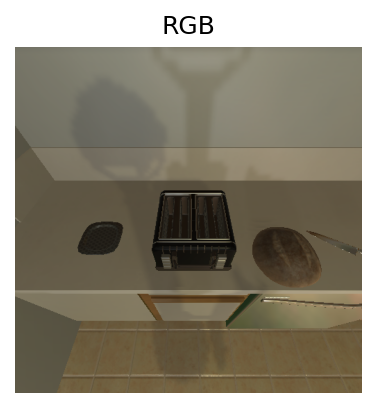

In [ ]:
# Reset the AI2-THOR controller to load the specified scene
# and configure rendering parameters
controller.reset(
    scene = task_context["scene"],
    visibilityDistance=1.5,
    gridSize=0.05,
    fieldOfView=90,
    width=500,
    height=500,
    renderDepthImage=False,
    renderNormalsImage=False,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False
)

# Prepare and send object poses to the controller
object_poses = []
for object_init_state in task_context["objects_init_state"]:
    object_poses.append(
        {
            "objectName": object_init_state["objectName"],
            "position": object_init_state["position"],
            "rotation": object_init_state["rotation"],
        }
    )
controller.step(action="SetObjectPoses", objectPoses=object_poses)
controller.step(action="Done")

# Teleport the agent to its initial position and orientation
controller.step(
    action="Teleport",
    position=task_context['robot_init_state']['position'],
    rotation=task_context['robot_init_state']['rotation'],
    horizon=task_context['robot_init_state']['horizon'],
    standing=True,
)
# Render and display the current camera view
plot_frames(controller.last_event)

from PIL import Image
import numpy as np

# Save initial scene for multimodal planning
rgb_frame = controller.last_event.frame  # (H, W, 3) RGB array
rgb_image = Image.fromarray(rgb_frame)
rgb_image.save("/content/init_scene.png")

Develop a controller wrapper for AI2-THOR that

*   initializes scenes based on a task-context dictionary,
*   executes high-level action classes (e.g., open, close, pick up), and
*   records events and RGB frames for subsequent analysis or video generation.

In [ ]:
import os
import json
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from ai2thor.controller import Controller
from ai2thor.platform import Linux64, CloudRendering
from actions import get_action_classes
from plan_success_checker import check_task_success


class Thor:
    """Thin wrapper around AI2-THOR’s Controller that:
       • sets up the scene from a task-context dictionary
       • executes high-level action classes (open, close, pick-up, …)
       • logs events / RGB frames for later analysis or video creation
    """

    def __init__(self, task_context: dict, scenario_idx: int, records_dir: str):
        """Create a Thor helper and immediately initialize the simulator."""
        self.controller = None
        self.counter = 0
        self.task_context = task_context
        self.records_dir = records_dir
        self.log_archive = {}

        # Available high-level actions (parsed from natural language commands).
        self.action_space = get_action_classes()
        self.init_env()

    # ----------------------------------------------------------------------
    # Environment setup
    # ----------------------------------------------------------------------
    def init_env(self):
        """Reset the AI2-THOR scene, place objects, and teleport the agent."""
        self.controller = Controller()
        # Scene-level parameters (FOV, resolution, etc.)
        self.controller.reset(
            scene=self.task_context["scene"],
            visibilityDistance=1.5,
            gridSize=0.05,
            fieldOfView=90,
            width=500,
            height=500,
            renderDepthImage=False,
            renderNormalsImage=False,
            renderInstanceSegmentation=False,
            renderSemanticSegmentation=False,
        )

        # Place all task-specific objects at their initial poses
        object_poses = [
            {
                "objectName": obj["objectName"],
                "position": obj["position"],
                "rotation": obj["rotation"],
            }
            for obj in self.task_context["objects_init_state"]
        ]
        self.controller.step(action="SetObjectPoses", objectPoses=object_poses)
        self.controller.step(action="Done")

        # Teleport the agent to its start pose (position, rotation, horizon)
        self.controller.step(
            action="Teleport",
            position=self.task_context["robot_init_state"]["position"],
            rotation=self.task_context["robot_init_state"]["rotation"],
            horizon=self.task_context["robot_init_state"]["horizon"],
            standing=True,
        )
        self.controller.step(action="Done")

    # ----------------------------------------------------------------------
    # Convenience properties
    # ----------------------------------------------------------------------
    @property
    def is_hand_empty(self) -> bool:
        """True if the agent is not holding any object."""
        return self.agent_state["isHolding"] is None

    @property
    def agent_state(self) -> dict:
        """Return the current agent metadata with an extra 'isHolding' field."""
        event = self.controller.last_event
        agent = event.metadata["agent"]
        agent["isHolding"] = None
        # Determine which object (if any) is currently picked up
        for obj in self.objects_state:
            if obj.get("pickupable") and obj.get("isPickedUp"):
                agent["isHolding"] = obj
                break
        return agent

    @property
    def objects_state(self) -> list:
        """Return metadata for all objects visible in the current frame."""
        return self.controller.last_event.metadata["objects"]

    @property
    def rgb_frame(self) -> np.ndarray:
        """Return the current RGB image rendered by AI2-THOR."""
        return self.controller.last_event.frame

    # ----------------------------------------------------------------------
    # Object-lookup helpers
    # ----------------------------------------------------------------------
    def get_objectsByType(self, objectType: str) -> list:
        """Return all objects of a given AI2-THOR objectType."""
        return [o for o in self.objects_state if o["objectType"].lower() == objectType.lower()]

    def get_objectById(self, objectId: str):
        """Return a single object by its unique objectId (or None)."""
        return next((o for o in self.objects_state if o["objectId"] == objectId), None)

    def get_objectByName(self, objectName: str):
        """Return a single object by its human-readable name (or None)."""
        return next((o for o in self.objects_state if o["name"] == objectName), None)

    def get_closestObject(self, objects: list):
        """Given a list of objects, return the one closest to the agent."""
        agent_pos = self.agent_state["position"]

        def euclidean(p):
            return ((p["x"] - agent_pos["x"]) ** 2 + (p["y"] - agent_pos["y"]) ** 2 + (p["z"] - agent_pos["z"]) ** 2) ** 0.5

        return min(objects, key=lambda o: euclidean(o["position"])) if objects else None

    # ----------------------------------------------------------------------
    # Logging utilities
    # ----------------------------------------------------------------------
    def log(self, success: bool, message: str):
        """Print and archive a log message for the current frame counter."""
        if not message:
            return
        tag = "[INFO]" if success else "[ERROR]"
        msg = f"Frame {self.counter:03d} | {tag} {message}"
        print(msg)
        self.log_archive[self.counter] = msg

    def save_data(self, log_flag: bool = True):
        """Save the current event + RGB frame and advance the frame counter."""
        if log_flag:
            os.makedirs(f"{self.records_dir}/events", exist_ok=True)
            with open(f"{self.records_dir}/events/step_{self.counter}.pickle", "wb") as f:
                pickle.dump(self.controller.last_event, f, protocol=pickle.HIGHEST_PROTOCOL)

        os.makedirs(f"{self.records_dir}/ego_img", exist_ok=True)
        plt.imsave(
            f"{self.records_dir}/ego_img/step_{self.counter}.png",
            np.asarray(self.rgb_frame, order="C"),
        )
        self.counter += 1


## 1. Zero-shot Task Planner
Write a zero-shot prompt (no examples) to perform the **toastBread** task. Your prompt must adhere to the **two prompt requirements** at the top of this notebook.


###  1.1 Zero-shot Prompt Formulation
Compose a prompt and copy/paste it into ChatGPT-4o (or another LLM) to generate the JSON plan.

In [ ]:
########################## TODO ##########################
# Generate Zero-shot Prompt

prompt = """
You are a robotic task planner.

Your task is to generate a plan to complete the given instruction using only the specified action templates and objects.

Task: Slice bread, store the knife in the drawer, heat the bread and serve it on the plate on the countertop.

Objects:
- knife
- bread
- drawer
- toaster
- plate
- countertop

Init States:
- plate is on countertop
- toaster is off
- bread is unsliced
- knife is on countertop

Available action templates (use only these forms):
- "close" <object>
- "open" <object>
- "pick up" <object>
- "place" <object> "in" <object>
- "place" <object> "on" <object>
- "slice" <object>
- "turn off" <object>
- "turn on" <object>

Instructions:
- Each action must strictly match one of the templates above.
- Use only the provided objects.
- Return only a JSON object where keys are step numbers as strings and values are action strings.
- Do not include any explanations or reasoning — return only the JSON plan.

Plan:
"""
##########################################################

print("=== Zero-shot Prompt ===\n")
print(prompt)

=== Zero-shot Prompt ===


You are a robotic task planner.

Your task is to generate a plan to complete the given instruction using only the specified action templates and objects.

Task: Slice bread, store the knife in the drawer, heat the bread and serve it on the plate on the countertop.

Objects:
- knife
- bread
- drawer
- toaster
- plate
- countertop

Init States:
- plate is on countertop
- toaster is off
- bread is unsliced
- knife is on countertop

Available action templates (use only these forms):
- "close" <object>
- "open" <object>
- "pick up" <object>
- "place" <object> "in" <object>
- "place" <object> "on" <object>
- "slice" <object>
- "turn off" <object>
- "turn on" <object>

Instructions:
- Each action must strictly match one of the templates above.
- Use only the provided objects.
- Return only a JSON object where keys are step numbers as strings and values are action strings.
- Do not include any explanations or reasoning — return only the JSON plan.

Plan:



###   1.2 JSON Plan Acquisition via LLM
Copy/paste the JSON task plan, generated by your LLM, into the TODO section below. So, we extract a sequence of actions.  

In [ ]:
import json
import time

# Create Thor instance
thor = Thor(task_context, scenario_idx=-1, records_dir="test/ZeroShot/")

########################## TODO ##########################
# JSON plan obtained from the LLM
zero_shot_answer = """
{
  "1": "pick up knife",
  "2": "pick up bread",
  "3": "slice bread",
  "4": "place knife in drawer",
  "5": "place bread in toaster",
  "6": "turn on toaster",
  "7": "pick up bread",
  "8": "place bread on plate"
}
"""
##########################################################

# Convert JSON string to a Python dict
plan_dict = json.loads(zero_shot_answer)

# Iterate through the dict in step order and create action objects
actions = []
for step, action_string in sorted(plan_dict.items(), key=lambda x: int(x[0])):
    for action_class in thor.action_space:
        action_args = action_class.parse(action_string)
        if action_args is not None:
            actions.append(action_class(thor, action_args))
            break


### 1.3 Execution in the AI2-THOR Environment

Simulate the plan and verify why the generated plan

In [ ]:
print("\n==========================================")
print("Action Execution")
print("==========================================")

# Execute actions sequentially
for idx, action in enumerate(actions, start=1):
    print(f"{idx}. Executing: {action}")
    action.execute()
    thor.log(success=True, message=f"after {action}")
    time.sleep(1)


Action Execution
1. Executing: <actions.pickup_action.PickUp object at 0x78aa6a829710>
Frame 000 | [INFO] pick up knife
Frame 001 | [INFO] pick up knife succeeded
Frame 002 | [INFO] after <actions.pickup_action.PickUp object at 0x78aa6a829710>
2. Executing: <actions.pickup_action.PickUp object at 0x78aa6a829610>
Frame 002 | [INFO] pick up bread
Frame 003 | [ERROR] pick up bread failed: Precondition Violation for pick up bread: pick up bread failed: Robot is already holding an object, cannot pick up Bread
Frame 004 | [INFO] after <actions.pickup_action.PickUp object at 0x78aa6a829610>
3. Executing: <actions.slice_object.Slice object at 0x78aa6a8298d0>
Frame 004 | [INFO] slice bread
Frame 005 | [INFO] slice bread succeeded
Frame 006 | [INFO] after <actions.slice_object.Slice object at 0x78aa6a8298d0>
4. Executing: <actions.placein_action.PlaceIn object at 0x78aa6a828f50>
Frame 006 | [INFO] place knife in drawer
Frame 007 | [ERROR] place knife in drawer failed: Precondition Violation for

In [ ]:
import imageio, glob, os, numpy as np, PIL

# Convert saved PNG frames into an MP4 video
def make_video_from_frames(records_dir, output_fname="plan_execution.mp4", fps=4):
    img_dir = os.path.join(records_dir, "ego_img")
    pngs = sorted(glob.glob(f"{img_dir}/step_*.png"),
                  key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split("_")[-1]))
    if not pngs:
        print("No frames to make video.")
        return
    out_path = os.path.join(records_dir, output_fname)
    with imageio.get_writer(out_path, fps=fps) as writer:
        for p in pngs:
            img = PIL.Image.open(p).convert("RGB")
            writer.append_data(np.array(img))
    print(f"Saved video: {out_path}")

# Build the video
if __name__ == "__main__":
    make_video_from_frames(
            records_dir=thor.records_dir,
            output_fname="ZeroShot.mp4",
            fps=4
        )

# Play the execution video for the ZeroShot plan
from IPython.display import Video
Video("test/ZeroShot/ZeroShot.mp4", embed=True, width=400)

Saved video: test/ZeroShot/ZeroShot.mp4


## 2. Few-shot Task Planner
Write a few-shot prompt (include 1–2 demonstration examples) to perform the **toastBread** task. Your prompt must adhere to the **two prompt requirements** at the top of this notebook.

###  2.1 Few-shot Prompt Formulation
Compose a prompt and copy/paste it into ChatGPT-4o (or another LLM) to generate the JSON plan.

In [ ]:
########################## TODO ##########################
# Generate Few-shot Prompt

prompt = """You are a robotic task planner.

Your task is to generate a plan to complete the given instruction using only the specified action templates and objects.

Task: Boil the tomato in a pot and place the pot on the countertop.

Objects:
- tomato
- pot
- sink
- faucet
- stoveburner
- countertop

Available action templates (use only these forms):
- "close" <object>
- "open" <object>
- "pick up" <object>
- "place" <object> "in" <object>
- "place" <object> "on" <object>
- "slice" <object>
- "turn off" <object>
- "turn on" <object>

Instructions:
- Each action must strictly match one of the templates above.
- Use only the provided objects.
- Return the result as a JSON object where keys are step numbers as strings (e.g., "1", "2", ...) and values are action strings.
- Do not include any explanations or reasoning — return only the JSON plan.

Example:
{
  "1": "pick up tomato",
  "2": "place tomato in pot",
  "3": "pick up pot",
  "4": "place pot in sink",
  "5": "turn on faucet",
  "6": "turn off faucet",
  "7": "pick up pot",
  "8": "place pot on stoveburner",
  "9": "turn on stoveburner",
  "10": "pick up pot",
  "11": "place pot on countertop"
}

Task: Slice bread, store the knife in the drawer, heat the bread and serve it on the plate on the countertop.

Objects:
- knife
- bread
- drawer
- toaster
- plate
- countertop

Init States:
- plate is on countertop
- toaster is off
- bread is unsliced
- knife is on countertop

Plan:
"""
##########################################################

print("=== Few-shot Prompt ===\n")
print(prompt)

=== Few-shot Prompt ===

You are a robotic task planner.

Your task is to generate a plan to complete the given instruction using only the specified action templates and objects.

Task: Boil the tomato in a pot and place the pot on the countertop.

Objects:
- tomato
- pot
- sink
- faucet
- stoveburner
- countertop

Available action templates (use only these forms):
- "close" <object>
- "open" <object>
- "pick up" <object>
- "place" <object> "in" <object>
- "place" <object> "on" <object>
- "slice" <object>
- "turn off" <object>
- "turn on" <object>

Instructions:
- Each action must strictly match one of the templates above.
- Use only the provided objects.
- Return the result as a JSON object where keys are step numbers as strings (e.g., "1", "2", ...) and values are action strings.
- Do not include any explanations or reasoning — return only the JSON plan.

Example:
{
  "1": "pick up tomato",
  "2": "place tomato in pot",
  "3": "pick up pot",
  "4": "place pot in sink",
  "5": "turn o

###   2.2 JSON Plan Acquisition via LLM
Copy/paste the JSON task plan, generated by your LLM, into the TODO section below. So, we extract a sequence of actions.  

In [ ]:
# Create Thor instance
thor = Thor(task_context, scenario_idx=-1, records_dir="test/FewShot/")

########################## TODO ##########################
# JSON plan obtained from the LLM
few_shot_answer = """
{
  "1": "pick up knife",
  "2": "slice bread",
  "3": "open drawer",
  "4": "place knife in drawer",
  "5": "close drawer",
  "6": "pick up bread",
  "7": "place bread on toaster",
  "8": "turn on toaster",
  "9": "turn off toaster",
  "10": "pick up bread",
  "11": "place bread on plate"
}
"""
##########################################################

# Convert JSON string to a Python dict
plan_dict = json.loads(few_shot_answer)

# Iterate through the dict in step order and create action objects
actions = []
for step, action_string in sorted(plan_dict.items(), key=lambda x: int(x[0])):
    for action_class in thor.action_space:
        action_args = action_class.parse(action_string)
        if action_args is not None:
            actions.append(action_class(thor, action_args))
            break


### 2.3 Execution within the AI2-THOR Environment

Simulate the plan and verify why the generated plan

In [ ]:
print("\n==========================================")
print("Action Execution")
print("==========================================")

# Execute actions sequentially
for idx, action in enumerate(actions, start=1):
    print(f"{idx}. Executing: {action}")
    action.execute()
    thor.log(success=True, message=f"after {action}")
    time.sleep(1)


Action Execution
1. Executing: <actions.pickup_action.PickUp object at 0x78aa6a8b6b90>
Frame 000 | [INFO] pick up knife
Frame 001 | [INFO] pick up knife succeeded
Frame 002 | [INFO] after <actions.pickup_action.PickUp object at 0x78aa6a8b6b90>
2. Executing: <actions.slice_object.Slice object at 0x78aa6a8b7a10>
Frame 002 | [INFO] slice bread
Frame 003 | [INFO] slice bread succeeded
Frame 004 | [INFO] after <actions.slice_object.Slice object at 0x78aa6a8b7a10>
3. Executing: <actions.open_action.Open object at 0x78aa6a8b6d90>
Frame 004 | [INFO] open drawer
Frame 005 | [INFO] open drawer succeeded
Frame 006 | [INFO] after <actions.open_action.Open object at 0x78aa6a8b6d90>
4. Executing: <actions.placein_action.PlaceIn object at 0x78aa6a8b7490>
Frame 006 | [INFO] place knife in drawer
Frame 007 | [INFO] place knife in drawer succeeded
Frame 008 | [INFO] after <actions.placein_action.PlaceIn object at 0x78aa6a8b7490>
5. Executing: <actions.close_action.Close object at 0x78aa6a8b7e90>
Frame 

In [ ]:
import imageio, glob, os, numpy as np, PIL

# Convert saved PNG frames into an MP4 video
def make_video_from_frames(records_dir, output_fname="plan_execution.mp4", fps=4):
    img_dir = os.path.join(records_dir, "ego_img")
    pngs = sorted(glob.glob(f"{img_dir}/step_*.png"),
                  key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split("_")[-1]))
    if not pngs:
        print("No frames to make video.")
        return
    out_path = os.path.join(records_dir, output_fname)
    with imageio.get_writer(out_path, fps=fps) as writer:
        for p in pngs:
            img = PIL.Image.open(p).convert("RGB")
            writer.append_data(np.array(img))
    print(f"Saved video: {out_path}")

# Build the video
if __name__ == "__main__":
    make_video_from_frames(
            records_dir=thor.records_dir,
            output_fname="FewShot.mp4",
            fps=4
        )

# Play the execution video for the FewShot plan
from IPython.display import Video
Video("test/FewShot/FewShot.mp4", embed=True, width=400)

Saved video: test/FewShot/FewShot.mp4


## 3. Multi-Modal Task Planner
- Use the image at `content/init_scene.png` to let the LLM infer all relevant objects and their current states.  
- Based on those inferred objects and states, craft a zero-shot prompt (no examples) that generates a JSON task plan for the **toastBread** task, adhering to the two common prompt requirements at the top of this notebook.


###  3.1 Multi-Modal Prompt Formulation
Compose a prompt and copy/paste it into ChatGPT-4o (or another LLM) to generate the JSON plan.

In [ ]:
########################## TODO ##########################
# Generate Multi-Modal Prompt

prompt = """You see the following image of a kitchen scene.

Task: Slice bread, store the knife in the drawer, heat the bread and serve it on the plate on the countertop.

Identify all relevant objects and their states.

Then generate a numbered plan to perform the toastBread task using only these actions:
Available action templates (use only these forms):
- "close" <object>
- "open" <object>
- "pick up" <object>
- "place" <object> "in" <object>
- "place" <object> "on" <object>
- "slice" <object>
- "turn off" <object>
- "turn on" <object>


Instructions:
- Each action must strictly match one of the templates above.
- Use only the provided objects.
- Return the result as a JSON object where keys are step numbers as strings (e.g., "1", "2", ...) and values are action strings.
- Do not include any explanations or reasoning — return only the JSON plan.

Plan:"""
##########################################################

print("=== MultiModal Prompt ===\n")
print(prompt)

=== MultiModal Prompt ===

You see the following image of a kitchen scene.

Task: Slice bread, store the knife in the drawer, heat the bread and serve it on the plate on the countertop.

Identify all relevant objects and their states).

Then generate a numbered plan to perform the toastBread task using only these actions:
Available action templates (use only these forms):
- "close" <object>
- "open" <object>
- "pick up" <object>
- "place" <object> "in" <object>
- "place" <object> "on" <object>
- "slice" <object>
- "turn off" <object>
- "turn on" <object>


Instructions:
- Each action must strictly match one of the templates above.
- Use only the provided objects.
- Return the result as a JSON object where keys are step numbers as strings (e.g., "1", "2", ...) and values are action strings.
- Do not include any explanations or reasoning — return only the JSON plan.

Plan:


###   3.2 JSON Plan Acquisition via LLM
Copy/paste the JSON task plan, generated by your LLM, into the TODO section below. So, we extract a sequence of actions.  

In [ ]:
import json
import time

# Create Thor instance
thor = Thor(task_context, scenario_idx=-1, records_dir="test/MultiModal/")

########################## TODO ##########################
# JSON plan obtained from the LLM
multi_modal_answer = """
{
  "1": "pick up knife",
  "2": "slice bread",
  "3": "place knife in drawer",
  "4": "open toaster",
  "5": "pick up bread",
  "6": "place bread in toaster",
  "7": "turn on toaster",
  "8": "turn off toaster",
  "9": "pick up bread",
  "10": "place bread on plate"
}
"""
##########################################################

# Convert JSON string to a Python dict
plan_dict = json.loads(multi_modal_answer)

# Iterate through the dict in step order and create action objects
actions = []
for step, action_string in sorted(plan_dict.items(), key=lambda x: int(x[0])):
    for action_class in thor.action_space:
        action_args = action_class.parse(action_string)
        if action_args is not None:
            actions.append(action_class(thor, action_args))
            break


### 3.3 Execution within the AI2-THOR Environment

Simulate the plan and verify why the generated plan

In [ ]:
print("\n==========================================")
print("Action Execution")
print("==========================================")

# Execute actions sequentially
for idx, action in enumerate(actions, start=1):
    print(f"{idx}. Executing: {action}")
    action.execute()
    thor.log(success=True, message=f"after {action}")
    time.sleep(1)


Action Execution
1. Executing: <actions.pickup_action.PickUp object at 0x78aa6a7bf390>
Frame 000 | [INFO] pick up knife
Frame 001 | [INFO] pick up knife succeeded
Frame 002 | [INFO] after <actions.pickup_action.PickUp object at 0x78aa6a7bf390>
2. Executing: <actions.slice_object.Slice object at 0x78aa6a7bf790>
Frame 002 | [INFO] slice bread
Frame 003 | [INFO] slice bread succeeded
Frame 004 | [INFO] after <actions.slice_object.Slice object at 0x78aa6a7bf790>
3. Executing: <actions.placein_action.PlaceIn object at 0x78aa6a7bfc50>
Frame 004 | [INFO] place knife in drawer
Frame 005 | [ERROR] place knife in drawer failed: Precondition Violation for place knife in drawer: Drawer is not open
Frame 006 | [INFO] after <actions.placein_action.PlaceIn object at 0x78aa6a7bfc50>
4. Executing: <actions.open_action.Open object at 0x78aa6a7bedd0>
Frame 006 | [INFO] open toaster
Frame 007 | [ERROR] open toaster failed: Precondition Violation for open toaster: open toaster failed: Toaster is not an op

In [ ]:
import imageio, glob, os, numpy as np, PIL

# Convert saved PNG frames into an MP4 video
def make_video_from_frames(records_dir, output_fname="plan_execution.mp4", fps=4):
    img_dir = os.path.join(records_dir, "ego_img")
    pngs = sorted(glob.glob(f"{img_dir}/step_*.png"),
                  key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split("_")[-1]))
    if not pngs:
        print("No frames to make video.")
        return
    out_path = os.path.join(records_dir, output_fname)
    with imageio.get_writer(out_path, fps=fps) as writer:
        for p in pngs:
            img = PIL.Image.open(p).convert("RGB")
            writer.append_data(np.array(img))
    print(f"Saved video: {out_path}")

# Build the video
if __name__ == "__main__":
    make_video_from_frames(
            records_dir=thor.records_dir,
            output_fname="MultiModal.mp4",
            fps=4
        )

# Play the execution video for the MultiModal plan
from IPython.display import Video
Video("test/MultiModal/MultiModal.mp4", embed=True, width=400)

Saved video: test/MultiModal/MultiModal.mp4


## 4: Autoregressive Task Planning & Consistent State Estimation



### 📌 Why it matters

A robot can’t just follow a to-do list.  
It must account for how the world changes after each action to ensure that subsequent actions remain valid.

- After slicing the bread, the state **“bread is sliced”** must remain.  
  If the robot forgets this, it might slice the bread again or take the wrong step.
- In long plans, missing even one state update can **invalidate the entire plan**.

This assignment teaches you to:
1. **Update the state after every step**,  
2. Ensure the **next action’s preconditions are satisfied**, and  
3. Confirm at the end that the **goal condition is met**.

→ These skills keep long-horizon plans from falling apart.



Use the image at `content/init_scene.png` to complete the following tasks:

---

#### ✅ Step 1: Scene Understanding

Use the image to identify and list:
- All **relevant objects** in the scene
- The **initial state** of each object  
  _e.g._ `"knife is on counter"`, `"drawer is closed"`

You will use these for the `objects` and `init_state` fields in the plan.

---

#### ✅ Step 2: Zero-shot Prompting for Task Planning

Craft a **zero-shot prompt** (no examples) that instructs the LLM to generate a complete JSON plan for the `toastBread` task.

---

### 📌 Output Format (must follow exactly):

```json
{
  "task": "<task_name>",
  "objects": ["<object_1>", "<object_2>", ...],
  "goal_condition": ["<goal_condition_1>", ...],
  "init_state": ["<initial_state_1>", ...],
  "steps": [
    {
      "action": "<action>",
      "precondition": ["<precondition_1>", ...],
      "effect": ["<effect_1>", ...],
      "state": ["<state_1>", ...]
    },
    ...
  ]
}
```

### ⚙️ Permitted Action Templates

The `action` field in each step **must strictly match** one of the following formats:

- `"pick up" <object>`
- `"place" <object> "in" <object>`
- `"place" <object> "on" <object>`
- `"open" <object>`
- `"close" <object>`
- `"turn on" <object>`
- `"turn off" <object>`
- `"slice" <object>`

🚫 **Do not create new action types or modify the format.**

---

### 🎯 Important Requirements

1. The `steps` must be generated **autoregressively**, meaning:
   - Each step’s `state` must result from applying the `effect` to the previous step’s `state`.
   - The next step’s `precondition` must be satisfied by the current `state`.

2. You must **track all necessary state changes throughout the entire plan**.
   - For example, if `"bread is sliced"` appears after slicing, it must **persist** in future states unless changed.
   - Do **not** drop or forget valid state facts.

3. The **final `state`** in the last step must fully satisfy the `goal_condition`.
   - This enables automatic validation of task success.

4. The prompt must be written **cleanly and unambiguously** to support **true zero-shot generation**.


In [ ]:
########################## TODO ##########################
# Generate Multi-Modal Task-Relevant State Estimation Prompt

prompt = """
You are a helpful task‑planning module for a robotic arm

Generate a logically valid <plan> to accomplish the <task>, utilizing identifiers defined with EBNF.

<object> = "A phrase that describes a physically distinct entity including robotic arm."
<relationship> = "A phrase that describes action-based or spatial connections between two <object>s."
<attribute> = "A phrase that describes dynamic properties of an <object> itself that can be changed through <action>s."
<state> = <object> "is" (<attribute> | <relationship> <object>)
<goal_condition> = <object> "must be" (<attribute> | <relationship> <object>)
<precondition> = <object> "must be" (<attribute> | <relationship> <object>)
<effect> = <object> "will" ["no longer"] "be" (<attribute> | <relationship> <object>)

Follow these steps:
1. Identify every visible <object> in the <scene>.
2. Define <goal_condition> for the <task> using the identified <object>s.
3. Describe <init_state> of the <scene> using the identified <object>s.
4. Iterate over <action>s step‑by‑step according to the following logic:
  1) Select an applicable <action> whose <precondition> holds true in the previous <state> and that is most likely to update the <state> to be closer to a state satisfying the <goal_condition>.
  2) Describe the <precondition> and <effect> of the selected <action> with identified <object>s.
  3) Update the <state> based on the <effect> by adding and removing elements describing <attribute> or <relationship>.
  4) Terminate the iteration if <state> satisfies the <goal_condition>.
5. Format your <plan> in JSON as follows:
{"task": <task>, "objects": [{<object>}], "goal_condition": [<goal_condition>], "init_state": [<init_state>], "steps": [{"action": <action>, "precondition": [<precondition>], "effect": [<effect>], "state": [<state>]}]}

<inits_state> = "robotic arm is holding nothing," <state>
<task> = "slice bread, store the knife in the drawer, heat the bread and serve it on the plate."
<action> = '"pick up" <object>'|
    '"place" <object> "in" <object>'|
    '"place" <object> "on" <object>'|
    '"open" <object>'|
    '"close" <object>'|
    '"turn on" <object>'|
    '"turn off" <object>'|
    '"slice" <object>'
<scene> =

Return only the final <plan> output, no explanation.

"""
##########################################################

print("=== EBNF Prompt ===\n")
print(prompt)

=== EBNF Prompt ===


You are a helpful task‑planning module for a robotic arm

Generate a logically valid <plan> to accomplish the <task>, utilizing identifiers defined with EBNF.

<object> = "A phrase that describes a physically distinct entity including robotic arm."
<relationship> = "A phrase that describes action-based or spatial connections between two <object>s."
<attribute> = "A phrase that describes dynamic properties of an <object> itself that can be changed through <action>s."
<state> = <object> "is" (<attribute> | <relationship> <object>)
<goal_condition> = <object> "must be" (<attribute> | <relationship> <object>)
<precondition> = <object> "must be" (<attribute> | <relationship> <object>)
<effect> = <object> "will" ["no longer"] "be" (<attribute> | <relationship> <object>)

Follow these steps:
1. Identify every visible <object> in the <scene>.
2. Define <goal_condition> for the <task> using the identified <object>s.
3. Describe <init_state> of the <scene> using the identif

In [ ]:
########################## TODO ##########################
task_relevant_state_estimation_answer = """
{
  "task": "slice bread, store the knife in the drawer, heat the bread and serve it on the plate.",
  "objects": [
    "robotic arm",
    "bread",
    "knife",
    "toaster",
    "plate",
    "drawer"
  ],
  "goal_condition": [
    "bread must be sliced",
    "bread must be heated",
    "bread must be on plate",
    "knife must be in drawer"
  ],
  "init_state": [
    "robotic arm is holding nothing",
    "bread is on counter",
    "knife is on counter",
    "toaster is on counter",
    "plate is on counter",
    "drawer is closed"
  ],
  "steps": [
    {
      "action": "pick up knife",
      "precondition": ["knife must be on counter", "robotic arm must be holding nothing"],
      "effect": ["knife will be held by robotic arm", "knife will no longer be on counter", "robotic arm will no longer be holding nothing"],
      "state": [
        "knife is held by robotic arm",
        "bread is on counter",
        "toaster is on counter",
        "plate is on counter",
        "drawer is closed"
      ]
    },
    {
      "action": "slice bread",
      "precondition": ["bread must be on counter", "knife must be held by robotic arm"],
      "effect": ["bread will be sliced"],
      "state": [
        "knife is held by robotic arm",
        "bread is sliced",
        "toaster is on counter",
        "plate is on counter",
        "drawer is closed"
      ]
    },
    {
      "action": "open drawer",
      "precondition": ["drawer must be closed"],
      "effect": ["drawer will be open", "drawer will no longer be closed"],
      "state": [
        "knife is held by robotic arm",
        "bread is sliced",
        "toaster is on counter",
        "plate is on counter",
        "drawer is open"
      ]
    },
    {
      "action": "place knife in drawer",
      "precondition": ["knife must be held by robotic arm", "drawer must be open"],
      "effect": ["knife will be in drawer", "knife will no longer be held by robotic arm", "robotic arm will be holding nothing"],
      "state": [
        "bread is sliced",
        "toaster is on counter",
        "plate is on counter",
        "drawer is open",
        "knife is in drawer",
        "robotic arm is holding nothing"
      ]
    },
    {
      "action": "pick up bread",
      "precondition": ["bread must be sliced", "robotic arm must be holding nothing"],
      "effect": ["bread will be held by robotic arm", "robotic arm will no longer be holding nothing"],
      "state": [
        "bread is held by robotic arm",
        "toaster is on counter",
        "plate is on counter",
        "drawer is open",
        "knife is in drawer"
      ]
    },
    {
      "action": "place bread in toaster",
      "precondition": ["bread must be held by robotic arm"],
      "effect": ["bread will be in toaster", "bread will no longer be held by robotic arm", "robotic arm will be holding nothing"],
      "state": [
        "bread is in toaster",
        "toaster is on counter",
        "plate is on counter",
        "drawer is open",
        "knife is in drawer",
        "robotic arm is holding nothing"
      ]
    },
    {
      "action": "turn on toaster",
      "precondition": ["bread must be in toaster"],
      "effect": ["bread will be heated"],
      "state": [
        "bread is heated",
        "toaster is on counter",
        "plate is on counter",
        "drawer is open",
        "knife is in drawer",
        "robotic arm is holding nothing"
      ]
    },
    {
      "action": "pick up bread",
      "precondition": ["bread must be heated", "robotic arm must be holding nothing"],
      "effect": ["bread will be held by robotic arm", "robotic arm will no longer be holding nothing"],
      "state": [
        "bread is held by robotic arm",
        "toaster is on counter",
        "plate is on counter",
        "drawer is open",
        "knife is in drawer"
      ]
    },
    {
      "action": "place bread on plate",
      "precondition": ["bread must be held by robotic arm", "plate must be on counter"],
      "effect": ["bread will be on plate", "bread will no longer be held by robotic arm", "robotic arm will be holding nothing"],
      "state": [
        "bread is on plate",
        "toaster is on counter",
        "drawer is open",
        "knife is in drawer",
        "robotic arm is holding nothing"
      ]
    }
  ]
}
"""